----------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------

## **Credit Risk Intelligence**

## **NOMS & PRENOMS : NGUEGUIM ALOTSE CHRISTY PEGGY**

--------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Compréhension du problème**



Notre défi principal est de classer des clients en deux catégories : "bons payeurs" et "mauvais payeurs", en fonction de leur capacité à rembourser leurs crédits.

Plus précisément, notre objectif est de détecter la majorité, voire l’ensemble, des mauvais payeurs afin d'éviter de leur accorder un crédit, et ainsi, protéger l'entreprise contre les risques de faillite.  Pour ce faire, nous allons concevoir des modèles de machine learning spécialement adaptés à cette problématique.

Pour mener à bien cette mission, nous disposons de deux jeux de données : l’un contenant les caractéristiques des clients, et l’autre contenant les éléments nécessaires à la construction de notre variable cible, à savoir : bon client/mauvais client.

Notre démarche s’articulera autour de plusieurs étapes clés : une analyse des variables, leur transformation et prétraitement, la mise en place de modèles prédictifs, l’optimisation de leurs performances, et une synthèse finale basée sur les résultats obtenus. Ce processus rigoureux nous permettra d'atteindre notre objectif tout en garantissant une prise de décision éclairée.




## **Importation de quelques packages**

In [46]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


---------------------------------------------------------------------------------------------------------------------------------------------------------

## **Importation du jeu de données**

### **Importation des données pour contruire la variable d'interet**

In [47]:
data = pd.read_csv("credit_record.csv")
data

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


### **Présentation du jeu de données**

Le jeu de données que nous avons importé contient trois variables : l’**ID** du client, la colonne **STATUS**, qui reflète le niveau de solvabilité des individus mois par mois, et **MONTHS_BALANCE**, qui indique la période correspondante.

------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Création de la variable d'intéret**

Pour créer la variable d’intérêt, nous devons identifier les individus à qualifier de bons ou de mauvais clients. À cet effet, nous allons générer une nouvelle variable appelée Y_STATUS, qui représentera notre variable d’intérêt et que nous allons traiter dans les prochains blocs de code.

### **Création de la colonne Y_STATUS**

In [48]:
data["Y_STATUS"] = data["STATUS"]

data.head()

,ID,MONTHS_BALANCE,STATUS,Y_STATUS
0,5001711,0,X,X
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,C


### **Construction de la variable d'interet**

#### **Matrice de transition**

In [49]:

# Trier les données par client et mois (descendant)
df1 = data.sort_values(by=['ID', 'MONTHS_BALANCE'], ascending=[True, False])

# Ajouter une colonne pour le statut du mois suivant
df1['NEXT_STATUS'] = df1.groupby('ID')['STATUS'].shift(-1)

# Filtrer pour éviter les valeurs manquantes (fin de l'historique d'un client)
transitions = df1.dropna(subset=['STATUS', 'NEXT_STATUS'])

# Compter les transitions
transition_counts = transitions.groupby(['STATUS', 'NEXT_STATUS']).size().unstack(fill_value=0)

# Normaliser pour obtenir des probabilités (par ligne)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Afficher la matrice de transition
print("Matrice de transition :")
transition_matrix

Matrice de transition :


NEXT_STATUS,0,1,2,3,4,5,C,X
STATUS,,,,,,,,
0,0.895638,0.015051,0.000589,0.000073,0.000031,0.000065,0.000000,0.088553
1,0.637086,0.308026,0.012368,0.001264,0.000000,0.000361,0.000090,0.040805
2,0.118664,0.644009,0.158986,0.025346,0.003456,0.008065,0.000000,0.041475
3,0.050000,0.018750,0.803125,0.087500,0.006250,0.015625,0.000000,0.018750
4,0.004484,0.000000,0.031390,0.829596,0.098655,0.000000,0.000000,0.035874
5,0.026005,0.001182,0.000000,0.001773,0.085697,0.861111,0.000000,0.024232
C,0.043170,0.002260,0.000145,0.000045,0.000061,0.000154,0.949556,0.004608
X,0.142556,0.002084,0.000189,0.000084,0.000042,0.000247,0.000000,0.854798


Grâce à cette matrice de transition, nous obtenons un aperçu clair de la situation de chaque individu dans cette base de données, ainsi que de leur capacité à être classés comme bons ou mauvais clients.  

Nous pouvons observer, par exemple, que les individus classés dans les catégories **C**, **0**, voire **X**, passent difficilement à des classes plus faibles. Ils ont plutôt tendance à rester dans la même classe, voire à migrer vers une classe supérieure.  

En revanche, les individus dans les classes les plus faibles (1, 2, 3, 4, 5) ont tendance à régresser vers une classe encore plus faible qu'elle. 

Ces observations nous donnent déjà des indications précieuses sur la manière dont nous allons classifier ces individus.

#### **Remplacement des modalités de la colonne Y_STATUS par 1: Bon client ou par 0: Mauvais client**

Les états 0 et C sont considérés comme des bons états de solvabilité

Les états 1,2,3,4,5 sont considérés comme des mauvais états de solvabilité

In [50]:
data["Y_STATUS"] = data["Y_STATUS"].replace(["0", "C"],1)  # Les états 0 ou C sont considérés comme des bons états de solvabilité

In [51]:
data["Y_STATUS"] = data["Y_STATUS"].replace(["1","2","3","4","5"],0)  # Les états 1,2,3,4,5 sont considérés comme des mauvais états de solvabilité

In [52]:
data["Y_STATUS"].value_counts()  # Fréquence des modalités de la variable Y_STATUS

Y_STATUS
1    825151
X    209230
0     14194
Name: count, dtype: int64

#### **Suppression des lignes ayant pour STATUS : X**

En nous basant sur la matrice de transition précédente, nous observons qu'un individu appartenant à la classe **X** change très rarement d’état. Étant donné que cette classe représente un état d’**absence de prêt**, elle ne semble pas fournir d'informations pertinentes pour distinguer la nature de bon ou mauvais payeur du client. Par conséquent, nous avons pris la décision de la supprimer.

In [53]:
data_sup = data[data["STATUS"] != "X"] 

In [54]:
data_sup["Y_STATUS"].value_counts()  # Fréquence des modalités de la variable Y_STATUS après suppression

Y_STATUS
1    825151
0     14194
Name: count, dtype: int64

**Étant donné que certains individus se répètent, nous allons conserver uniquement les observations uniques en gardant celle qui apparaît le plus fréquemment pour chaque individu.**

In [55]:
groupingg = data_sup.groupby("ID") #groupage par ID

In [56]:
new_data = groupingg.agg(lambda x: x.mode()[0]).reset_index() # Séléction du mode après groupage


#### **Fréquence des modalités de la colonne Y_STATUS**

In [57]:
#Nombre de lignes dans notre jeu de données contenant la variable d'intérêt créée et construite
new_data.shape[0] 

41449

In [58]:
(new_data["Y_STATUS"].value_counts())/41449

Y_STATUS
1    0.992979
0    0.007021
Name: count, dtype: float64

**Après création et construction de la variable Y_STATUS, on constate que la proportion des bons payeurs est nettement plus supérieure à celle des mauvais payeurs.**

-----------------------------------------------------------------------------------------------------------------------------------------------------

## **Création de la base de données incluant les caractéristiques et la variable d'interet**

**Une fois la variable d'intérêt correctement créée, nous allons maintenant l’intégrer au jeu de données contenant les caractéristiques des différents individus.**

### **Importation et présentation du jeu de données contenant les caractéristiques des individus**

#### **Importation du jeu de données**

In [59]:
df = pd.read_csv("application_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [60]:
df.shape

(438557, 18)

#### **Présentation du jeu de données**

Le jeu de données en question contient 18 colonnes, correspondant à 18 variables, qui décrivent environ 438 557 clients. Parmi ces caractéristiques, on retrouve des informations telles que le genre, le nombre d’enfants, la date d’embauche, la taille de la famille, le salaire, la situation matrimoniale, ainsi que divers indicateurs sur la possession ou non de certains éléments, comme des numéros de téléphone, des adresses e-mail, des voitures, etc.

### **Matching du jeu de données des caractéristiques avec la variable d'interet**

In [61]:
data_join = pd.merge(df, new_data, on='ID', how='left')

In [62]:
data_join.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Y_STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,C,1.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-13.0,C,1.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-28.0,0,1.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-2.0,0,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,NaN,NaN,NaN


**Une fois que notre jeu de données (comprenant les caractéristiques et la variable cible) est correctement construit, nous procéderons au retraitement et à l'analyse de nos différentes variables dans les codes qui suivent.**

-----------------------------------------------------------------------------------------------------------------------------------------------------

## **Retraitement des variables**

In [63]:
# Affichons le nombre de valeurs manquantes par variables

data_join.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
MONTHS_BALANCE         405447
STATUS                 405447
Y_STATUS               405447
dtype: int64

### **Retraitement de la variable Y_STATUS**

**Nous constatons que la colonne Y_STATUS présente des valeurs manquantes, ce qui pourrait compromettre la fiabilité de nos analyses. Plutôt que d’imputer ces valeurs manquantes, ce qui risquerait d’introduire des données erronées, nous avons choisi de supprimer ces lignes afin de minimiser l’impact des valeurs manquantes.**

In [64]:
data_maj = data_join[data_join["Y_STATUS"].notna()]

In [65]:
# Réinitialons les index de notre data frame après suppression

data_maj.reset_index(drop = True, inplace = True)

In [66]:
data_maj["Y_STATUS"].isna().sum() # Nombre de valeurs manquantes dans la colonne Y_STATUS après suppression

np.int64(0)

In [67]:
# Fréquence de la variable Y_STATUS après retraitement

(data_maj["Y_STATUS"].value_counts())

Y_STATUS
1.0    32853
0.0      257
Name: count, dtype: int64

### **Retraitement de la variable OCCUPATION_TYPE**

De manière similaire, nous constatons que la variable **OCCUPATION_TYPE** présente également des valeurs manquantes. Cependant, supprimer les lignes contenant ces valeurs manquantes risquerait de réduire l'information disponible. Par conséquent, nous avons décidé d'imputer cette variable **en remplaçant les valeurs manquantes par le mode de cette colonne**.

In [68]:
mode = data_maj["OCCUPATION_TYPE"].mode()[0]


data_maj["OCCUPATION_TYPE"] = data_maj["OCCUPATION_TYPE"].fillna(mode)

In [69]:
# Nombre de valeurs manquantes dans la colonne OCCUPATION_TYPE après emputation

data_maj["OCCUPATION_TYPE"].isna().sum()

np.int64(0)

----------------------------------------------------------------------------------------------------------------------------------------------------

## **Analyse de données**

### **Identifions le type de nos variables afin de mieux orienter nos analyses et la création de nos graphiques.**

In [70]:
# Informations générales sur notre jeu de données
data_maj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33110 entries, 0 to 33109
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33110 non-null  int64  
 1   CODE_GENDER          33110 non-null  object 
 2   FLAG_OWN_CAR         33110 non-null  object 
 3   FLAG_OWN_REALTY      33110 non-null  object 
 4   CNT_CHILDREN         33110 non-null  int64  
 5   AMT_INCOME_TOTAL     33110 non-null  float64
 6   NAME_INCOME_TYPE     33110 non-null  object 
 7   NAME_EDUCATION_TYPE  33110 non-null  object 
 8   NAME_FAMILY_STATUS   33110 non-null  object 
 9   NAME_HOUSING_TYPE    33110 non-null  object 
 10  DAYS_BIRTH           33110 non-null  int64  
 11  DAYS_EMPLOYED        33110 non-null  int64  
 12  FLAG_MOBIL           33110 non-null  int64  
 13  FLAG_WORK_PHONE      33110 non-null  int64  
 14  FLAG_PHONE           33110 non-null  int64  
 15  FLAG_EMAIL           33110 non-null 

### **Analyse exploratoire**

In [71]:
#data_maj.describe()

data_maj.describe(include = 'all')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Y_STATUS
count,3.311000e+04,33110,33110,33110,33110.000000,3.311000e+04,33110,33110,33110,33110,...,33110.000000,33110.0,33110.000000,33110.000000,33110.000000,33110,33110.000000,33110.000000,33110,33110.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,...,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,6,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,...,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,0,NaN
freq,NaN,22220,20618,22288,NaN,NaN,17077,22554,22725,29579,...,NaN,NaN,NaN,NaN,NaN,15974,NaN,NaN,19774,NaN
mean,5.078015e+06,NaN,NaN,NaN,0.427756,1.858772e+05,NaN,NaN,NaN,NaN,...,60031.029085,1.0,0.224011,0.292419,0.090396,NaN,2.194654,-25.429236,NaN,0.992238
std,4.187679e+04,NaN,NaN,NaN,0.741716,1.014124e+05,NaN,NaN,NaN,NaN,...,138345.184712,0.0,0.416936,0.454881,0.286752,NaN,0.911076,16.364444,NaN,0.087761
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,...,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,NaN,0.000000
25%,5.041983e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,...,-3159.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-38.000000,NaN,1.000000
50%,5.069441e+06,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,...,-1552.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,NaN,1.000000
75%,5.114633e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,...,-405.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-11.000000,NaN,1.000000


Cette analyse exploratoire nous fournit des informations sur plusieurs aspects des colonnes de notre DataFrame :

- Dans la variable **CODE_GENDER**, il semble que les femmes soient plus nombreuses que les hommes, avec une fréquence de 22 220 pour les femmes contre 10 890 pour les hommes, selon la fonction **top**.

- Il apparaît également que la majorité des clients de cette base de données ne possèdent pas leur propre voiture, avec 20 618 personnes sans véhicule contre 12 492 avec un véhicule.

- Il semble que la majorité des clients soient mariés.

- La majorité des clients vivent dans des maisons ou des appartements.

En résumé, grâce à cette première analyse, nous pouvons déjà tirer quelques premières impressions sur les variables de notre jeu de données.

### **Retraitement des variables**

#### **Retraitement de la variable DAYS_BIRTH**

Grâce à l'analyse exploratoire réalisée précédemment, nous avons remarqué (en observant le min et le max) que, la colonne **DAYS_BIRTH** est exprimée en jours et que ses valeurs sont négatives. Avant de poursuivre, nous allons donc retraiter cette colonne en la convertissant en années et en la transformant en des valeurs positives.

In [72]:
data_maj["DAYS_BIRTH"] = data_maj["DAYS_BIRTH"]/ -365

data_maj["DAYS_BIRTH"]

0        32.890411
1        32.890411
2        58.832877
3        52.356164
4        52.356164
           ...    
33105    47.528767
33106    33.936986
33107    33.936986
33108    49.200000
33109    25.172603
Name: DAYS_BIRTH, Length: 33110, dtype: float64

### **Analyse univariée**

In [73]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from scipy.stats import pearsonr

#### **Representation de la variable DAYS_EMPLOYED**

In [29]:

# Création du boxplot avec Plotly
fig = px.box(data_maj, y="DAYS_EMPLOYED", title="Days Employed")

# Personnalisation de l'axe des valeurs
fig.update_layout(
    yaxis_title="Valeurs",
    xaxis_title="",
)

# Affichage du graphique
fig.show()



Ce boxplot révèle une valeur extrême supérieure à 300 000. Cette valeur écrase notre graphique et aplatit le boxplot. Cela soulève des interrogations sur l'origine de cette valeur extrême, sa signification réelle, ainsi que son impact sur le jeu de données et sur les modélisations futures. Afin d’y voir plus clair, nous allons revenir à la définition de la variable **DAYS_EMPLOYED** et analyser son fonctionnement.

En effet, **DAYS_EMPLOYED** représente la date de début d'emploi, plus précisément un compte à rebours à partir du jour actuel (0). Si la valeur est positive, cela indique que la personne est actuellement sans emploi.

Dans le cas de cette valeur extrême de 300 000, le modèle risque de lui attribuer un poids disproportionné en raison de sa grandeur. Cependant, cette valeur représente une situation où la personne n’a pas de travail. Une telle interprétation erronée pourrait biaiser les résultats du modèle.

Ainsi, pour éviter tout impact négatif, il est nécessaire d’effectuer un retraitement de cette colonne **DAYS_EMPLOYED** afin de corriger ce problème et d'assurer une meilleure qualité des analyses.

### **Retraitement de la variable DAYS_EMPLOYED**

In [80]:
# Création de deux nouvelles variables

data_maj["EMPLOYED"] = data_maj["DAYS_EMPLOYED"]
data_maj["UNEMPLOYED"] =  data_maj["DAYS_EMPLOYED"]

# Construction de la variable employed

data_maj["EMPLOYED"] = data_maj["EMPLOYED"].apply(lambda x: 1 if x < 0 else (0 if x > 0 else x))


# Construction de la variable unemployed

data_maj["UNEMPLOYED"] = data_maj["UNEMPLOYED"].apply(lambda x: 1 if x > 0 else (0 if x < 0 else x))


In [83]:
data_maj.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Y_STATUS,EMPLOYED,UNEMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,Laborers,2.0,-14.0,C,1.0,1,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,Laborers,2.0,-13.0,C,1.0,1,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,-28.0,0,1.0,1,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,-2.0,0,1.0,1,0
4,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,-24.0,C,1.0,1,0


In [78]:
data_maj["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
 365243    5642
-401         62
-1539        61
-2087        57
-1678        57
           ... 
-2507         1
-1427         1
-4135         1
-4276         1
-606          1
Name: count, Length: 3566, dtype: int64

#### **Representation de la variable CODE_GENDER**

Text(0.5, 1.0, 'Répartition des genres')

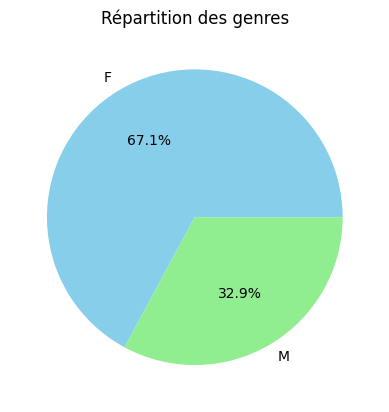

In [27]:
# Obtention des valeurs comptées
valeurs = data_maj["CODE_GENDER"].value_counts()

# Création des labels pour chaque catégorie
labels = valeurs.index  # Les catégories 'M', 'F'.

# Création du diagramme circulaire
plt.pie(valeurs, labels=labels, colors=['skyblue', 'lightgreen'], autopct='%1.1f%%')

# Ajouter un titre
plt.title('Répartition des genres')

**Ce diagramme circulaire confirme les résultats de l'analyse exploratoire, indiquant qu'il y a plus de femmes que d'hommes dans notre jeu de données.**

#### **Representation de la variable OCCUPATION_TYPE**

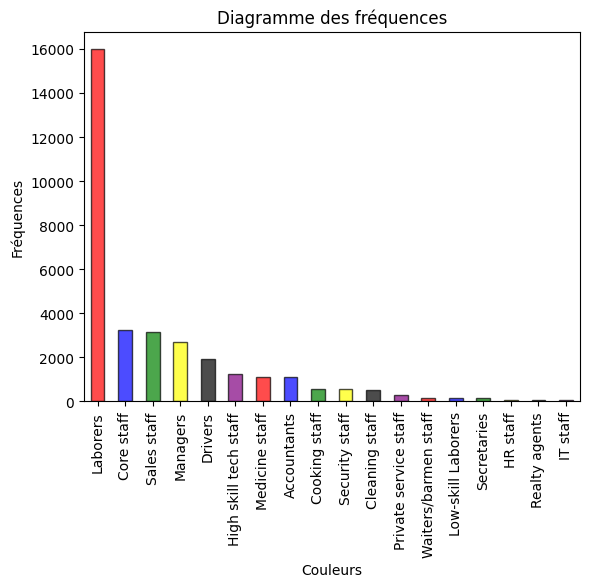

In [84]:
# Calculer les fréquences
frequences = data_maj['OCCUPATION_TYPE'].value_counts()

# Tracer le diagramme des fréquences
frequences.plot(kind='bar', color=['red', 'blue', 'green', 'yellow', "black","purple"], edgecolor='black', alpha=0.7)

# Ajouter des labels et un titre
plt.title("Diagramme des fréquences")
plt.xlabel("Couleurs")
plt.ylabel("Fréquences")

# Afficher le graphique
plt.show()


**Ce diagramme des fréquences de la variable OCCUPATION_TYPE met en évidence qu'une grande majorité des clients exerce le métier de laboureur, tandis que les IT staff représentent le groupe le plus petit en termes d'effectif. Mais qu'est-ce que cela pourrait signifier pour la suite de notre analyse ?**

### **Analyse bivariée**



In [85]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from scipy.stats import pearsonr

#### **Representation de la variable OCCUPATION_TYPE et de la variable Y_STATUS**

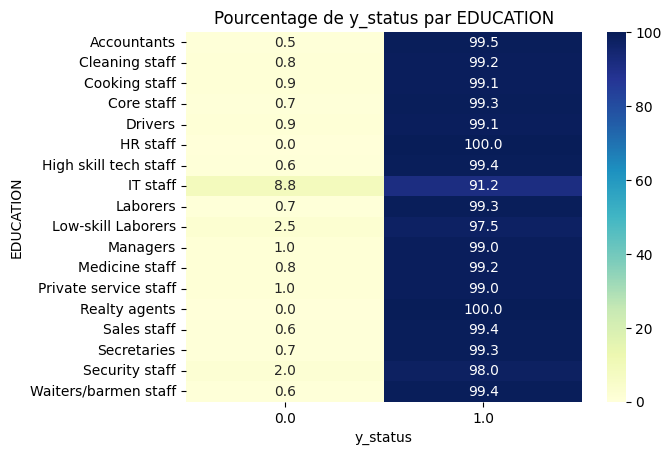

In [89]:
cross_tab_education = pd.crosstab(data_maj['OCCUPATION_TYPE'], data_maj['Y_STATUS'], normalize='index') * 100
#print(cross_tab_education)

# Heatmap
sns.heatmap(cross_tab_education, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title("Pourcentage de y_status par EDUCATION")
plt.xlabel("y_status")
plt.ylabel("EDUCATION")
plt.show()

**Ce heatmap montre que, de manière générale, les clients, quel que soit leur métier, sont plutôt de bons payeurs. Cependant, les "IT staff" (personnel informatique) se distinguent par une proportion plus élevée de mauvais payeurs. Toutefois, étant donné leur faible effectif, il serait raisonnable de penser que leur impact sur l'ensemble des données reste marginal et ne représente pas une tendance générale significative.**

#### **Representation de la variable NAME_HOUSING_TYPE et de la variable Y_STATUS**

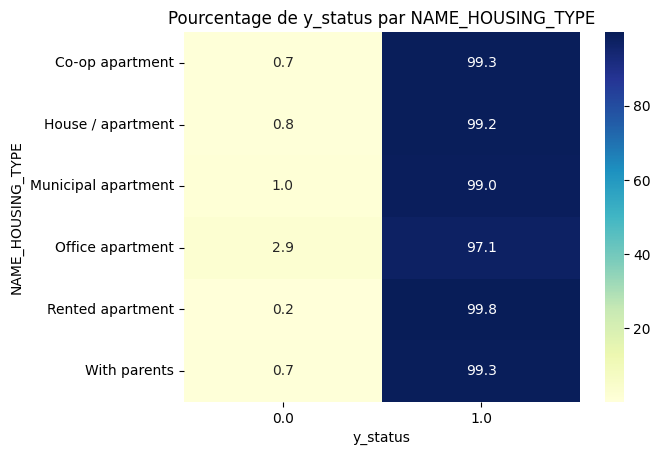

In [87]:
cross_tab_housing = pd.crosstab(data_maj['NAME_HOUSING_TYPE'], data_maj['Y_STATUS'], normalize='index') * 100
#print(cross_tab_housing)

# Heatmap
sns.heatmap(cross_tab_housing, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title("Pourcentage de y_status par NAME_HOUSING_TYPE")
plt.xlabel("y_status")
plt.ylabel("NAME_HOUSING_TYPE")
plt.show()

**Ce heatmap, illustrant le pourcentage de bons et mauvais clients par type de logement, révèle que tous les types de logement comptent une majorité de bons clients. Toutefois, les clients résidant dans des appartements municipaux ou des appartements de bureau affichent une légère proportion de mauvais clients.**

### **Analyse multivariée**

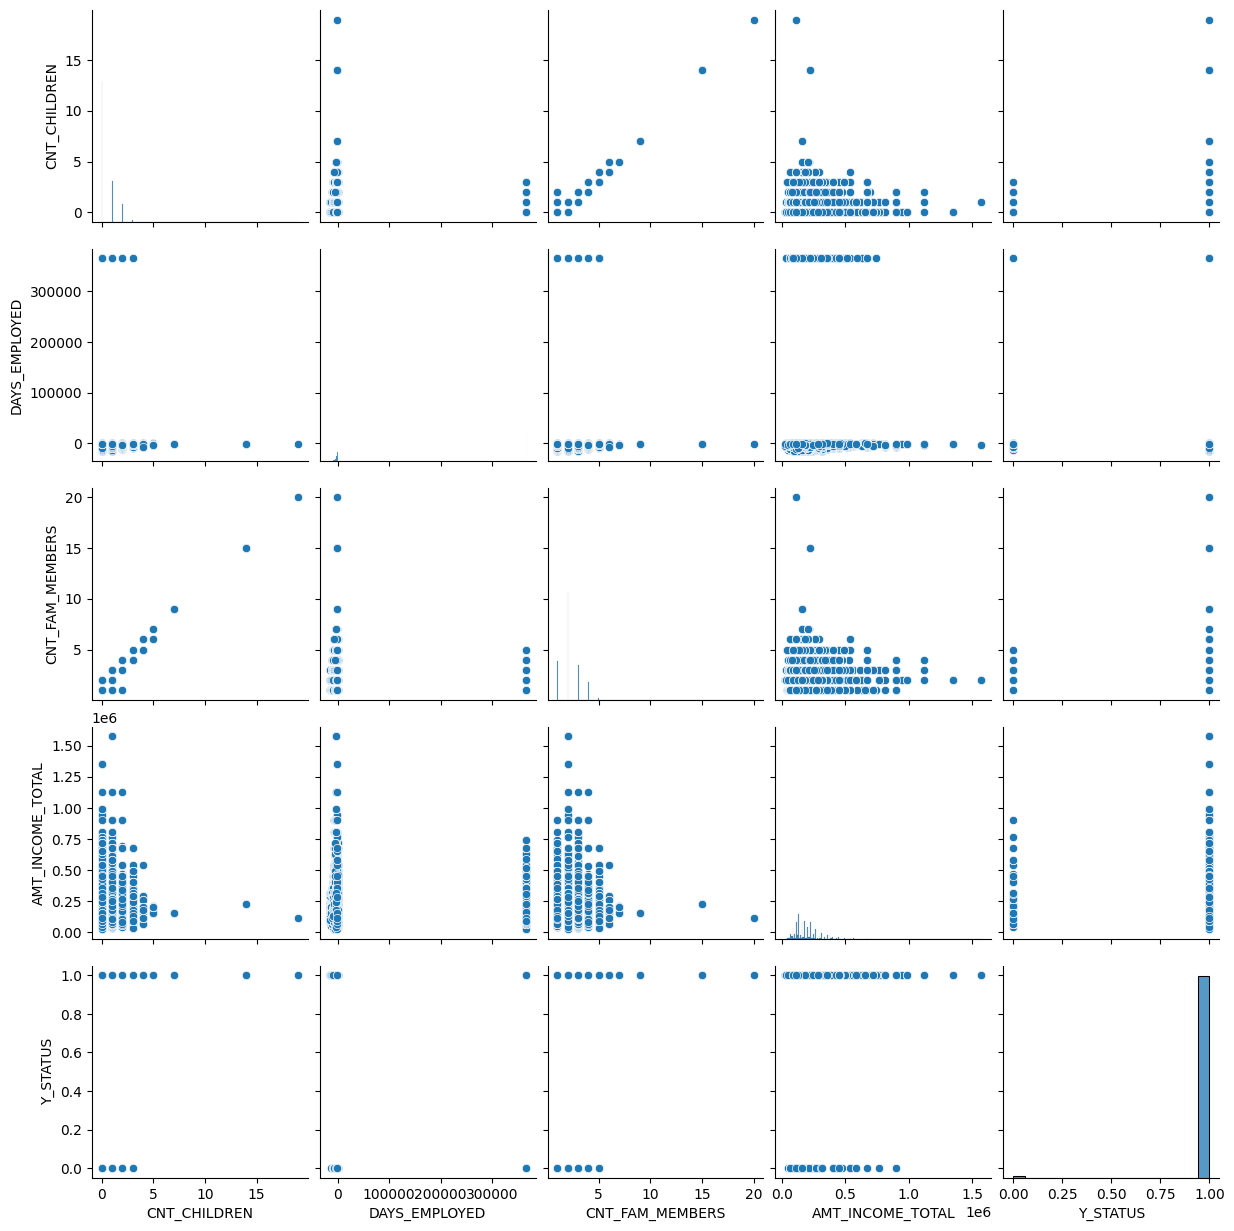

In [90]:
sns.pairplot (data_maj[["CNT_CHILDREN", "DAYS_EMPLOYED", "CNT_FAM_MEMBERS", "AMT_INCOME_TOTAL", "Y_STATUS"]])
plt.show()

**Ce pairplot semble indiquer qu'il n'y a pas de lien linéaire évident entre les différentes variables considérées. Les points sont dispersés, ce qui suggère qu'aucune relation directe et linéaire ne se dégage entre les paires de variables observées. Cela pourrait signifier qu'il faut envisager d'autres types d'analyses ou de transformations des données pour mieux comprendre les relations entre ces variables.**

----------------------------------------------------------------------------------------------------------------------------------------------------------

## **Détection des anomalies**

In [91]:
from sklearn.ensemble import IsolationForest

In [94]:
# Sélection de toutes les variables numériques, sauf de Y_STATUS


data_numeric_except_one = data_maj.select_dtypes(exclude=['object']).drop(columns=['Y_STATUS'])



In [96]:
data_numeric_except_one.head()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,EMPLOYED,UNEMPLOYED
0,5008804,0,427500.0,32.890411,-4542,1,1,0,0,2.0,-14.0,1,0
1,5008805,0,427500.0,32.890411,-4542,1,1,0,0,2.0,-13.0,1,0
2,5008806,0,112500.0,58.832877,-1134,1,0,0,0,2.0,-28.0,1,0
3,5008808,0,270000.0,52.356164,-3051,1,0,1,1,1.0,-2.0,1,0
4,5008810,0,270000.0,52.356164,-3051,1,0,1,1,1.0,-24.0,1,0


In [97]:
#Initialisation du modèle
model = IsolationForest(contamination=0.1)  # 10% de contamination attendue : sert à indiquer la proportion approximative d'anomalies attendues dans vos données.

#Entraînement du modèle
model.fit(data_numeric_except_one)

# Prédictions des anomalies (-1 = anomalie, 1 = normal)
predictions = model.predict(data_numeric_except_one)

#### **Lignes de données identifiées comme anomalies par le modèle Isolation Forest**

In [98]:
predict_anomalies = (np.where(np.array(predictions) == -1))[0]
data_numeric_except_one.iloc[predict_anomalies , ]


,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,EMPLOYED,UNEMPLOYED
3,5008808,0,270000.0,52.356164,-3051,1,0,1,1,1.0,-2.0,1,0
4,5008810,0,270000.0,52.356164,-3051,1,0,1,1,1.0,-24.0,1,0
5,5008811,0,270000.0,52.356164,-3051,1,0,1,1,1.0,-36.0,1,0
6,5008812,0,283500.0,61.545205,365243,1,0,0,0,1.0,-19.0,0,1
7,5008813,0,283500.0,61.545205,365243,1,0,0,0,1.0,-15.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33058,5126184,0,94500.0,58.150685,365243,1,0,1,1,2.0,-5.0,0,1
33071,5139446,0,112500.0,58.235616,365243,1,0,1,0,1.0,-15.0,0,1
33072,5142185,2,450000.0,48.879452,-4305,1,1,1,0,4.0,-24.0,1,0
33085,5145690,0,306000.0,59.150685,365243,1,0,0,0,2.0,-16.0,0,1


## **Split des données**

In [99]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

##### **Variables explicatives**

In [101]:
# Variables Feature

data_ML_feature = data_maj.drop(columns=['ID', "DAYS_EMPLOYED", "Y_STATUS"])

In [102]:
data_ML_feature.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS', 'EMPLOYED',
       'UNEMPLOYED'],
      dtype='object')

##### **Target**

In [104]:
data_ML_target = data_maj["Y_STATUS"]

data_ML_target

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
33105    0.0
33106    0.0
33107    0.0
33108    1.0
33109    1.0
Name: Y_STATUS, Length: 33110, dtype: float64

##### **Split**

In [105]:
from sklearn.model_selection import train_test_split, cross_val_score

# Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_ML_feature, data_ML_target, test_size=0.3, random_state=42)

______________________________________________________________________________________________________________________________________________________

## **Preprocessing**

##### **Préparation des données au preprocessing**

In [107]:
quanti_col = data_ML_feature.select_dtypes(exclude=['object', 'category']).columns
quali_col = data_ML_feature.select_dtypes(include=['object', 'category']).columns


X_train_num = X_train[quanti_col]
X_train_cat = X_train[quali_col]

X_test_num = X_test[quanti_col]
X_test_cat = X_test[quali_col]


##### **Preprocessing proprement dit**

In [108]:
from sklearn.compose import ColumnTransformer
# Définir les colonnes numériques et catégoriques
numeric_features = data_ML_feature.select_dtypes(exclude=['object', 'category']).columns
categorical_features = data_ML_feature.select_dtypes(include=['object', 'category']).columns

# Définir les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)  # drop='first' pour éviter le dummy trap
    ])
    

# Appliquer les transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)





------------------------------------------------------------------------------------------------------------------------------------------------

## **Construction d'un modèle de Regression Logistique**

In [109]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

### **Entrainement du modèle**

In [110]:
model.fit(X_train_transformed, y_train)

LogisticRegression()

### **Coefficients**

In [ ]:
print (model.coef_)
print (model.intercept_)

[[ 4.23162386e-01  1.48320529e-01  1.12263939e-01  0.00000000e+00
  -6.54628056e-02  5.52357995e-03 -7.36638703e-02 -2.40963164e-01
  -4.50372302e-01 -1.50114503e-01  1.50114503e-01  2.84886594e-01
  -7.66651982e-02  1.98534970e-01  9.68642556e-03  1.50649949e-01
   5.75714465e-02 -2.72101843e-01 -9.08517595e-01  9.17703868e-01
   5.51783761e-03  4.65619128e-01  3.39053999e-02  3.10093424e-01
   3.47148185e-01 -4.88074554e-01  5.14894113e-03  7.62864552e-01
   2.71277536e-01 -7.77780451e-01  4.75112356e-03 -5.28913646e-02
  -7.91400236e-02  2.58026009e-01 -4.74219218e-01 -3.14043134e-01
   6.40796268e-01  1.76801494e-01  8.80296832e-01 -1.64874741e-01
  -3.99137994e-01  1.19959587e-01  1.93453924e-01  9.51666476e-02
  -1.07726335e-02 -1.12198511e+00  2.87143722e-01 -3.25207002e-01
   1.16837692e-01  1.54768681e-01 -5.84529639e-01  1.10786721e-01
   6.54099696e-01 -7.54981096e-02  1.00900341e-01  1.76812785e-01
   3.86969912e+00 -3.24946471e+00 -7.92903496e-01 -3.21942517e-01
  -4.35453

### **Evaluation du modèle**

In [114]:
y_predict = model.predict(X_test_transformed)


### **Métriques**

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

**Classe 1 = Bon client**

**Classe O = Mauvais client**

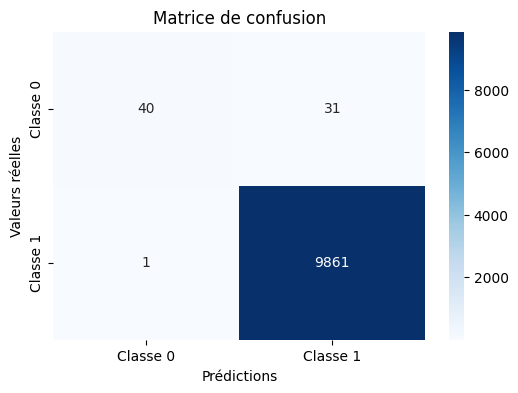

Accuracy: 0.9967784153830666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.56      0.71        71
         1.0       1.00      1.00      1.00      9862

    accuracy                           1.00      9933
   macro avg       0.99      0.78      0.86      9933
weighted avg       1.00      1.00      1.00      9933



In [121]:

# Matrice de confusion
cm = confusion_matrix(y_test, y_predict)

# Affichage de la matrice de confusion avec annotations
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Ajouter les labels
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')

# Affichage
plt.show()


# Accuracy
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

# Rapport de classification (inclut recall, précision, f1-score)
report = classification_report(y_test, y_predict)
print("Classification Report:\n", report)

### **Interpretation**

L’objectif principal de ces modèles de machine learning est de protéger l’entreprise contre la faillite en limitant les prêts accordés à des clients incapables de rembourser leurs dettes.

D’après la matrice de confusion du modèle de régression logistique, celui-ci a identifié 41 clients comme mauvais payeurs (classe 0). Parmi eux :

- 40 sont effectivement de mauvais payeurs,

- 1 a été incorrectement classé comme tel.

Cependant, en réalité, le nombre total de mauvais payeurs est de 71, ce qui signifie que le modèle a manqué 31 "vrais" mauvais clients. Le **recall** donné par le modèle pour cette classe est de **0,56 (40/71)**, ce qui signifie qu’il parvient à détecter un peu plus de la moitié des mauvais payeurs. Cela met en évidence une marge importante d’amélioration.

Afin de réduire davantage le risque de faillite, nous nous concentrerons sur l’optimisation des hyperparamètres pour améliorer le recall des mauvais clients (classe 0).

### **Hyperparamétrage_RegressionLogistique**

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# Initialisation du modèle
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# Définir la grille des hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Régularisation
    'class_weight': [None, 'balanced'],  # Poids des classes
}

# Définir le scorer basé sur le recall pour la classe 0
scorer = make_scorer(recall_score, pos_label=0)

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # Validation croisée
    n_jobs=-1,
    verbose=2,
)

# Exécuter la recherche
grid_search.fit(X_train_transformed, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Évaluer le modèle optimisé
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
print("Recall pour la classe 0 sur les données test :", recall_class_0)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres : {'C': 1, 'class_weight': 'balanced'}
Recall pour la classe 0 sur les données test : 0.7323943661971831


#### **Interprétation après l'optimisation des hyperparamètres du modèle de régression logistique.**

Le modèle obtenu après l'hyperparamétrage affiche une amélioration significative du **recall** pour la classe 0, **passant de 0,56 à 0,73**. Ce résultat, très encourageant, nous rapproche considérablement de l'objectif fixé. Cependant, il est important de noter qu'il reste possible d'atteindre un recall encore plus élevé.

## **Construction d'un modèle Ramdom Forest**

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

**Classe 1 = Bon client**

**Classe O = Mauvais client**

In [136]:
model_RF = RandomForestClassifier(n_estimators=100, random_state=1)

### **Entrainement du modèle**

In [137]:
model_RF.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=1)

### **Evaluation**

In [138]:
y_pred = model_RF.predict(X_test_transformed)


### **Métriques**

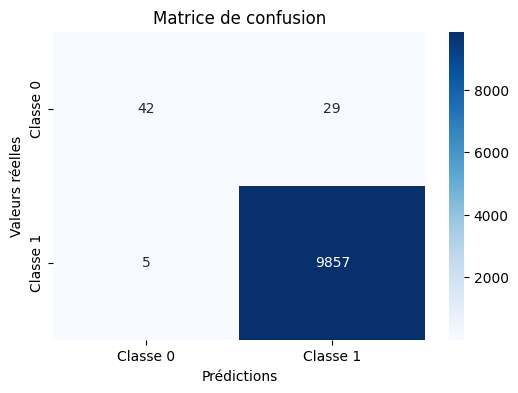

Accuracy: 0.9966777408637874
MSE: 0.003422933655491795
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.62      0.73        71
         1.0       1.00      1.00      1.00      9862

    accuracy                           1.00      9933
   macro avg       0.94      0.81      0.86      9933
weighted avg       1.00      1.00      1.00      9933



In [139]:

# Matrice de confusion
cmRF = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec annotations
plt.figure(figsize=(6, 4))
sns.heatmap(cmRF, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Ajouter les labels
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')

# Affichage
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# MSE
MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE)

# Rapport de classification (inclut recall, précision, f1-score)
report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", report)

### **Interpretation**

Voici une reformulation de votre texte :

L’objectif principal de l’utilisation de ces modèles de machine learning est de protéger l’entreprise contre la faillite en s’assurant qu’elle ne prête pas de l’argent à des clients qui ne seront pas en mesure de rembourser.

D’après la matrice de confusion du modèle Random Forest, 47 clients ont été classés comme mauvais (classe 0), dont 42 étaient effectivement de mauvais payeurs, tandis que 5 ne l’étaient pas. Cependant, la réalité montre qu'il y a en fait 71 mauvais clients.

Cela signifie que le modèle n’a pas réussi à détecter 29 "vrais" mauvais clients. Le **recall** du modèle pour la classe des mauvais payeurs est de **0,60 (soit 42/71)**, ce qui indique que le modèle parvient à identifier une grande partie des mauvais clients, mais qu'il reste encore des marges d'amélioration.

Pour atteindre notre objectif de prévenir la faillite, nous allons donc nous concentrer sur l’optimisation des hyperparamètres de ce modèle afin d'améliorer le recall des mauvais clients (classe 0).

### **Hyperparamétrage_RandomForest**

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# Définir la fonction de scoring pour le recall de la classe 0
scorer = make_scorer(recall_score, average=None, labels=[0])

# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],         # Nombre d'arbres
    'max_depth': [10, 20, None],            # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],          # Nombre minimum d'échantillons dans une feuille
    'class_weight': [None, 'balanced'],     # Poids des classes pour équilibrer les classes
    'max_features': ['sqrt', 'log2']        # Nombre de caractéristiques à considérer lors d'une division
}

# Initialiser le modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurer GridSearchCV avec la métrique de scoring personnalisée
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train_transformed, y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score de recall pour la classe 0
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score de recall pour la classe 0 :", grid_search.best_score_)

# Utiliser le modèle optimisé
best_model = grid_search.best_estimator_

# Évaluer le modèle sur les données de test
y_pred = best_model.predict(X_test_transformed)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
print("Recall pour la classe 0 sur les données de test :", recall_class_0)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs hyperparamètres : {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Meilleur score de recall pour la classe 0 : 0.6395448079658606
Recall pour la classe 0 sur les données de test : 0.6056338028169014


#### **Interprétation après l'optimisation des hyperparamètres du modèle de RandomForest.**



Le modèle optimisé par hyperparamétrage montre une légère amélioration du recall pour la classe 0, passant de 0,60 à 0,61. Bien que ce résultat ne soit pas très significatif, il est important de souligner qu'il existe encore des possibilités pour augmenter ce recall davantage.

## **Choix du modèle final**


Finalement, le choix du modèle que nous faisons s'oriente vers le modèle optimisé de régression logistique, car il présente une meilleure valeur de recall, atteignant **0,73**.

Avec ce modèle, nous sommes pratiquement certains de pouvoir détecter la majorité des mauvais payeurs, ce qui nous permettrait de ne pas leur accorder de crédit et ainsi éviter la faillite de l'entreprise. Il est cependant important de souligner qu'il reste encore des opportunités pour améliorer les performances de notre modèle et atteindre des résultats encore plus élevés.